In [1]:
import numpy as np
import cvxpy as cp
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
import gurobipy
import mosek
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import seaborn as sns
import pandas as pd
# My Code
import LearningMethod as lm
import DataGeneration as dg
import LinearProgramMethod as lpm
import OnlineMethod as om

In [270]:
# Generate Fractional Knapsack Samples
benchmark = 1
dim_features = 5
dim_decision = 10
price = np.random.randint(low=1, high=1000, size=dim_decision)
lower = np.amax(price)
upper = (np.random.rand()-1)*lower + np.sum(price)
Budget = [(upper-lower)*np.random.rand() + lower]
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)

In [271]:
N_train = 200
# N_valid = 200
N_test = 1000
degree = 1
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = 0.5
attack_power = 3.0
z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
#                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)

In [242]:
# Generate Shortest Path Samples
benchmark = 2
dim_edge_vert = 4
dim_edge_hori = 4
dim_features = 6
dim_cost = dim_edge_hori * (dim_edge_vert + 1) + (dim_edge_hori + 1) * dim_edge_vert
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_cost, dim_features))

In [243]:
N_train = 200
# N_valid = 200
N_test = 1000
degree = 6
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = 0.5
attack_power = 3.0
z_train, c_train, A_train, b_train = dg.GenerateShortestPath(N_samples = N_train, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateShortestPath(N_samples = N_valid, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
#                                                             dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
#                                                             degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
z_test, c_test, A_test, b_test = dg.GenerateShortestPath(N_samples = N_test, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)

In [272]:
# Compute Optimal Solutions
start = time.time()
basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
#basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
print("Time cost", time.time() - start)

Time cost 3.0479962825775146


Method Random Forest
Training samples 200
Time Cost 0.12495756149291992
Loss 0.03380842495184928 Error 0.25047181153666687 Normalized Error 0.20005805812298777


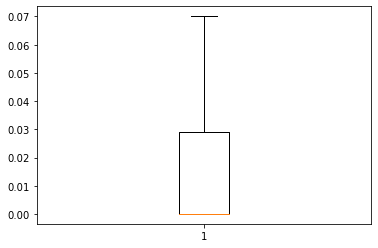

In [273]:
# Tuning Hyperparameters
# Random Forest
# No Theta, directly predict c
alg = 'RF'
print("Method Random Forest")
print("Training samples", N_train)
start = time.time()
regr = RandomForestRegressor(random_state=0)
regr.fit(z_train, c_train)
hat_c = regr.predict(z_test)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark, A=A_test, b=b_test, c=c_test, z=z_test,
                                                                                         direct=True, hat_c=hat_c, solved = True, solution=solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ordinary Least Squares
Training samples 200
Time Cost 0.5820002555847168
Loss 0.06832881583134345 Error 0.8609454182906243 Normalized Error 0.30683446896519434


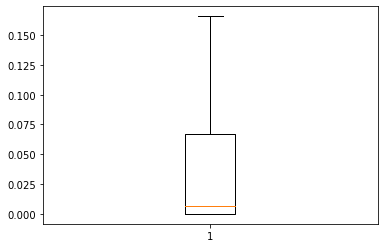

In [274]:
# Tuning Hyperparameters
# Ordinary Least Squares
alg = 'OLS'
print("Method Ordinary Least Squares")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.OrdinaryLeastSquares(A = A_train, b = b_train, c = c_train, z = z_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ridge Regression
Training samples 200
Time Cost 0.5272572040557861
Loss 0.06762272731016741 Error 0.8602416757934123 Normalized Error 0.30677793294300043


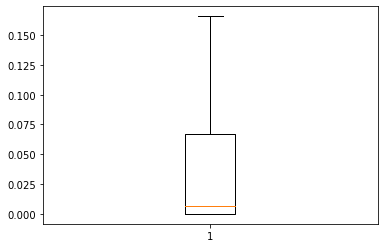

In [275]:
# Tuning Hyperparameters
# Ridge Regression
alg = 'Ridge'
print("Method Ridge Regression")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = z_train, regular_const = 1e-1)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method PolyKer Ridge Regression
Training samples 200
Time Cost 1.7030000686645508
Loss 0.029628839750320244 Error 0.39511874129708213 Normalized Error 0.161843641620592


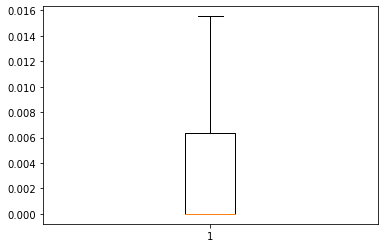

In [276]:
# Tuning Hyperparameters
# Polynomial Kernelized Ridge Regression
alg = 'PolyRidge'
print("Method PolyKer Ridge Regression")
print("Training samples", N_train)
ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=3, coef0=1.0)
ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=3, coef0=1.0)
start = time.time()
globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method RbfKer Ridge Regression
Training samples 200
Time Cost 1.6939995288848877
Loss 0.0058258116994683515 Error 0.30909323098222763 Normalized Error 0.08660323790949757


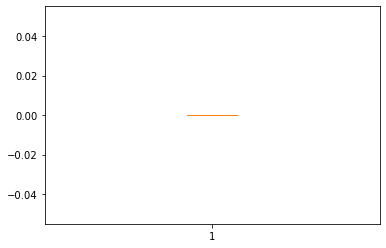

In [277]:
# Tuning Hyperparameters
# Rbf Kernelized Ridge Regression
alg = 'RbfRidge'
print("Method RbfKer Ridge Regression")
print("Training samples", N_train)
ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=5e-1)
ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=5e-1)
start = time.time()
globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SVM Margin Learning
Training samples 200
Time Cost 0.4699997901916504
Loss 0.0016915103812121025 Error 3.048441759363658 Normalized Error 0.9241851607594103


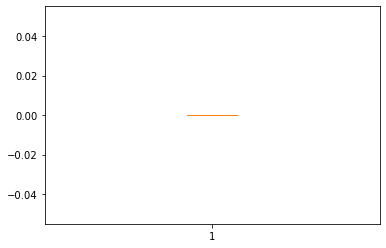

In [281]:
# Tuning Hyperparameters
# Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ML'
print("Method SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.MarginLearning(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train, 
                                            regular_const = 1e-3)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 4.7129998207092285
Loss 0.012294298375486162 Error 11.10446508098175 Normalized Error 0.937811749639154


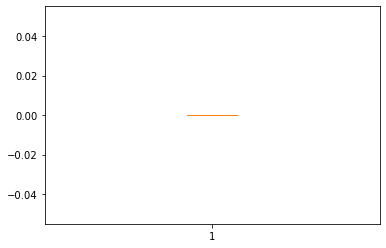

In [282]:
# Tuning Hyperparameters
# Polynomial Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'PolyKer'
ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
print("Method Poly-Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 4.519703149795532
Loss 0.011525851534170226 Error 2.6364014083571403 Normalized Error 0.9361232177352075


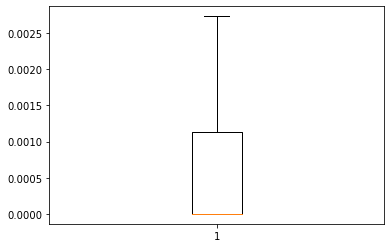

In [283]:
# Tuning Hyperparameters
# Rbf Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ExpRbf'
ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=2e0)
ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=2e0)
print("Method Rbf Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-3)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SPO+
Training samples 200


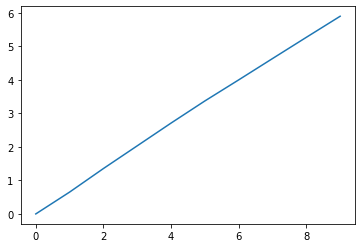

Time Cost 44.27845478057861
Loss 2.245773288724677 Error 0.990069238846126 Normalized Error 1.2254114398785507


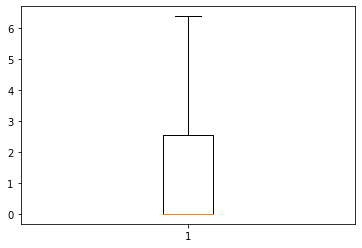

In [191]:
# Tuning Hyperparameters
# SPO+
alg = 'SPO'
print("Method SPO+")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SPOplus(A = A_train, b = b_train, c = c_train, z = z_train, 
                                     regular_const = 1e-2, step_size = 1e-1, batch_size = 5, max_iter = 1e3, 
                                     solved = True, solution = solution_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Naive OGD
Training samples 500
Time Cost 0.006976127624511719
Loss 1.8388770292478134 Error 2.0838786030458283 Normalized Error 1.4042543516428285


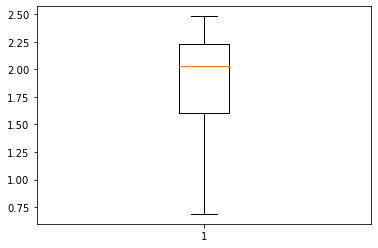

In [17]:
# Tuning Hyperparameters
# Naive Online Gradient Descent
# Do not need true c
alg = 'NOGD'
print("Method Naive OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.NaiveOnlineGradientDescent(A = A_train, b = b_train, z = z_train, 
                                                        step_size = 1e-3, solution = solution_train, radius = 50)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SVM OGD
Training samples 1000
Time Cost 0.0670003890991211
Loss 0.38048191031371514 Error 0.9994669064078309 Normalized Error 1.3105632225268369


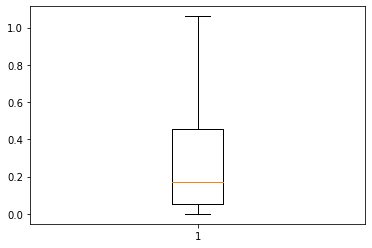

In [17]:
# Tuning Hyperparameters
# SVM Margin Online Gradient Descent
# Do not need true c
# Do not need solution x but basis
alg = 'SVMOGD'
print("Method SVM OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SVM_OGD(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train,
                                     step_size = 1e-4, radius = 1.1* np.linalg.norm(Coeff_Mat, 'f'), regular_const=1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

In [25]:
focus = "degree"
globals()[focus + "_set"] = [1, 2, 4, 6]
total_trial = 10
methods = ['RF', 'OLS', 'Ridge', 'PolyRidge', 'RbfRidge', 'SPO+', 'ML', 'PolyKer', 'ExpRbf']
for i in range(len(methods)):
    globals()[f"Loss_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Error_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Norm_Err_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))

*********************************************************
Trial 1
Time cost 3.4190027713775635
Method Random Forest
Training samples 500
Time Cost 0.2590024471282959
Loss 0.0689308523104141 Error 1.443655829147477 Normalized Error 0.3303979131814035
Method Ordinary Least Squares
Training samples 500
Time Cost 1.4760019779205322
Loss 0.13816068558522887 Error 13.759772708440257 Normalized Error 0.688204832367662
Method Ridge Regression
Training samples 500
Time Cost 1.4460008144378662
Loss 0.13816068558522887 Error 13.75941895862375 Normalized Error 0.688203448505963
Method PolyKer Ridge Regression
Training samples 500
Time Cost 15.01000428199768
Loss 0.1427749076125836 Error 13.875202401612075 Normalized Error 0.7306334410565074
Method RbfKer Ridge Regression
Training samples 500
Time Cost 14.918329000473022
Loss 0.1214197130701705 Error 0.6936184875990519 Normalized Error 0.3500908247613355
Method SPO+
Training samples 500


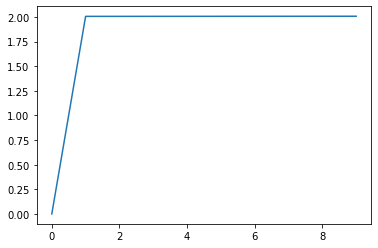

Time Cost 31.524288654327393
Loss 0.10720292338361422 Error 36.52404765074688 Normalized Error 1.3978091162864417
Method SVM Margin Learning
Training samples 500
Time Cost 1.3942339420318604
Loss 0.06383240379917424 Error 1.261525883004714 Normalized Error 1.1105474850041555
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 51.69140386581421
Loss 0.002577171708081382 Error 1.6071377065676906 Normalized Error 0.9108751050236342
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 48.36937880516052
Loss 0.01180816935742315 Error 1.272954832573912 Normalized Error 0.9663872901243747
*********************************************************
Trial 2
Time cost 3.2350001335144043
Method Random Forest
Training samples 500
Time Cost 0.24700140953063965
Loss 0.0712481482327115 Error 1.9380314486571049 Normalized Error 0.37566263196914496
Method Ordinary Least Squares
Training samples 500
Time Cost 1.5013422966003418
Loss 0.25489212395279676 Error 16.89

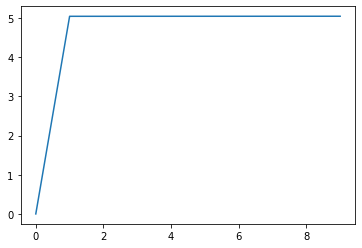

Time Cost 31.648157119750977
Loss 0.12891906332402447 Error 71.85730913051412 Normalized Error 1.4032277041952441
Method SVM Margin Learning
Training samples 500
Time Cost 1.4260022640228271
Loss 0.09535319610205831 Error 1.296713504246576 Normalized Error 1.1099457844393605
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 57.59605145454407
Loss 0.00209450525466644 Error 1.926647025536872 Normalized Error 0.9953458302848368
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 52.72133278846741
Loss 0.00747717052442394 Error 1.3276401166865779 Normalized Error 1.0245337919049315
*********************************************************
Trial 3
Time cost 3.253002166748047
Method Random Forest
Training samples 500
Time Cost 0.2610020637512207
Loss 0.11077070927932095 Error 1.4309286966180383 Normalized Error 0.384316485020029
Method Ordinary Least Squares
Training samples 500
Time Cost 1.4399986267089844
Loss 0.3326689769050315 Error 16.1470989

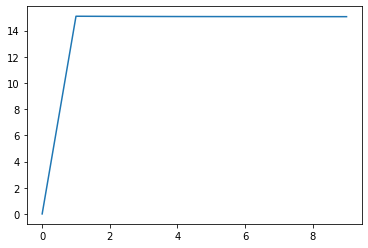

Time Cost 31.461053133010864
Loss 0.31978589845000377 Error 206.86661387135038 Normalized Error 1.41112051345624
Method SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 1.4610002040863037
Loss 0.28095078177935506 Error 1.5605842139524924 Normalized Error 1.183494199139257
Method Poly-Kernelized SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 55.421838998794556
Loss 0.0021344893919895054 Error 2.3934327169011884 Normalized Error 0.9540581412721904
Method Rbf Kernelized SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 61.823360443115234
Loss 0.01013387706335253 Error 1.8465697296336312 Normalized Error 1.03588069301481
*********************************************************
Trial 4
Time cost 4.026000738143921
Method Random Forest
Training samples 500
Time Cost 0.2689993381500244
Loss 0.046548449906923396 Error 0.4482330831563088

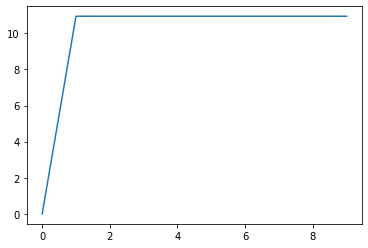

Time Cost 36.9726083278656
Loss 0.09304491913940452 Error 50.71827266548626 Normalized Error 1.4063049695635363
Method SVM Margin Learning
Training samples 500
Time Cost 1.6825668811798096
Loss 0.05929171339819463 Error 1.0936044622593053 Normalized Error 1.065796544823387
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 57.9434871673584
Loss 0.0015264849139358155 Error 1.2425070021300448 Normalized Error 0.9575793679778498
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 53.477463245391846
Loss 0.00517532284812243 Error 1.1323685351077533 Normalized Error 1.0127356681789694
*********************************************************
Trial 5
Time cost 3.371999740600586
Method Random Forest
Training samples 500
Time Cost 0.251004695892334
Loss 0.03005591474534912 Error 0.8659682602099941 Normalized Error 0.32001743590227083
Method Ordinary Least Squares
Training samples 500
Time Cost 1.667062520980835
Loss 0.1241723102513082 Error 6.6197737

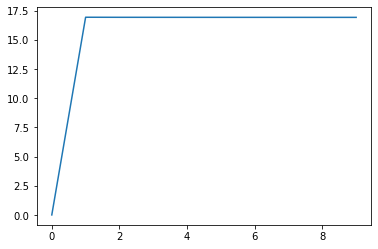

Time Cost 37.503313064575195
Loss 0.06797789751639068 Error 42.80650316233366 Normalized Error 1.4071136812391047
Method SVM Margin Learning
Training samples 500
Time Cost 1.5982375144958496
Loss 0.09787555474182273 Error 1.0006298165658347 Normalized Error 1.1199003788183026
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 66.46557784080505
Loss 0.0005114258731349267 Error 1.030677248935447 Normalized Error 0.9459730986154984
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 62.54811191558838
Loss 0.002455171231771498 Error 1.0169680348979766 Normalized Error 1.0039682919835922
*********************************************************
Trial 6
Time cost 4.458889007568359
Method Random Forest
Training samples 500
Time Cost 0.3021819591522217
Loss 0.0046324524607497366 Error 1.3792420230696538 Normalized Error 0.3893022940716713
Method Ordinary Least Squares
Training samples 500
Time Cost 1.6201481819152832
Loss 0.03083084245828605 Error 14

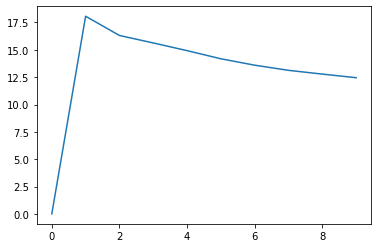

Time Cost 37.828362703323364
Loss 0.03423658824950797 Error 32.42103268957668 Normalized Error 1.4060996116816695
Method SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B i

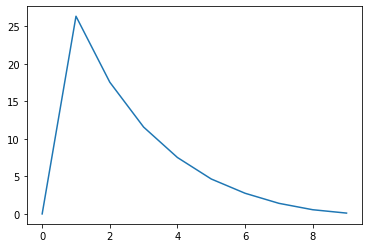

Time Cost 38.03765392303467
Loss 0.20581617817691467 Error 2.8073925649388123 Normalized Error 1.1862714412950532
Method SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B i

Time Cost 31.520647048950195
Loss 0.0003286697341352264 Error 1.5229527998261403 Normalized Error 1.1048518847729465
*********************************************************
Trial 8
Time cost 4.212001800537109
Method Random Forest
Training samples 500
Time Cost 0.29207563400268555
Loss 0.004565462968127841 Error 1.3248412115383605 Normalized Error 0.35976903351992334
Method Ordinary Least Squares
Training samples 500
Time Cost 1.5847809314727783
Loss 0.045614245894478704 Error 9.555627711796511 Normalized Error 0.7565887493835166
Method Ridge Regression
Training samples 500
Time Cost 1.544426679611206
Loss 0.045614245894478704 Error 9.555363017982458 Normalized Error 0.756588373453018
Method PolyKer Ridge Regression
Training samples 500
Time Cost 18.92702293395996
Loss 0.14050801428896562 Error 9.764751975442595 Normalized Error 0.7584259252839272
Method RbfKer Ridge Regression
Training samples 500
Time Cost 18.550423860549927
Loss 0.09795096024747742 Error 0.5338397788894035 Normaliz

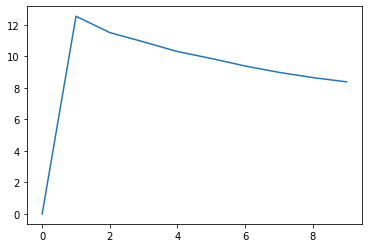

Time Cost 37.47823667526245
Loss 0.055671537986216116 Error 29.34173913815996 Normalized Error 1.403412945393033
Method SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 1.6541650295257568
Loss 0.005367282267736548 Error 1.121783638110859 Normalized Error 1.182566217013523
Method Poly-Kernelized SVM Margin Learning
Training samples 500
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular

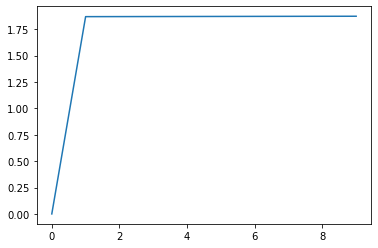

Time Cost 37.25338959693909
Loss 0.11773495197262068 Error 26.665664580572766 Normalized Error 1.3970986898741211
Method SVM Margin Learning
Training samples 500
Time Cost 1.5055971145629883
Loss 0.060427768590161544 Error 1.0792172036124328 Normalized Error 1.0867924606711235
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 59.33259129524231
Loss 0.0021612669730584166 Error 1.2997300846389057 Normalized Error 0.9692212813794135
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 49.764418601989746
Loss 0.007846290820052783 Error 1.1439076257437308 Normalized Error 1.0023783932007062
*********************************************************
Trial 10
Time cost 4.32668399810791
Method Random Forest
Training samples 500
Time Cost 0.28999948501586914
Loss 0.10201830031014532 Error 1.6756046599365908 Normalized Error 0.3963186101412571
Method Ordinary Least Squares
Training samples 500
Time Cost 1.6390018463134766
Loss 0.3871561359043627 Error 3

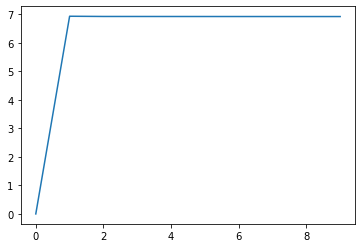

Time Cost 38.021010875701904
Loss 0.35304703032502155 Error 273.300301604782 Normalized Error 1.4105390699842202
Method SVM Margin Learning
Training samples 500
Time Cost 1.6060621738433838
Loss 0.3265319935654879 Error 2.64368404952127 Normalized Error 1.1484513077635334
Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 62.685537338256836
Loss 0.0026852320369299895 Error 4.0686356288297905 Normalized Error 0.9021007226271407
Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 61.24206495285034
Loss 0.007033837675025522 Error 3.6381518030370144 Normalized Error 0.9827974228825014


In [100]:
for trial in range(total_trial):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.randint(low=1, high=1000, size=dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 500
    # N_valid = 200
    N_test = 1000
    degree = 6
    additive_noise = 0.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.0
    attack_threshold = None
    attack_power = 0.0
    z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
    #                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    
    
    # Random Forest
    # No Theta, directly predict c
    alg = 'RF'
    print("Method Random Forest")
    print("Training samples", N_train)
    start = time.time()
    regr = RandomForestRegressor(random_state=0)
    regr.fit(z_train, c_train)
    hat_c = regr.predict(z_test)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark, A=A_test, b=b_test, c=c_test, z=z_test,
                                                                                             direct=True, hat_c=hat_c, solved = True, solution=solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Ordinary Least Squares
    alg = 'OLS'
    print("Method Ordinary Least Squares")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.OrdinaryLeastSquares(A = A_train, b = b_train, c = c_train, z = z_train)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Ridge Regression
    alg = 'Ridge'
    print("Method Ridge Regression")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = z_train, regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Polynomial Kernelized Ridge Regression
    alg = 'PolyRidge'
    print("Method PolyKer Ridge Regression")
    print("Training samples", N_train)
    ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Rbf Kernelized Ridge Regression
    alg = 'RbfRidge'
    print("Method RbfKer Ridge Regression")
    print("Training samples", N_train)
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e0)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e0)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    # SPO+
    alg = 'SPO+'
    print("Method SPO+")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.SPOplus(A = A_train, b = b_train, c = c_train, z = z_train, 
                                         regular_const = 1e-4, step_size = 1e-1, batch_size = 5, max_iter = 1e3, 
                                         solved = True, solution = solution_train)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ML'
    print("Method SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.MarginLearning(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train, 
                                                regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Polynomial Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'PolyKer'
    ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    print("Method Poly-Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=1e-1)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Rbf Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ExpRbf'
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e0)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e0)
    print("Method Rbf Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    

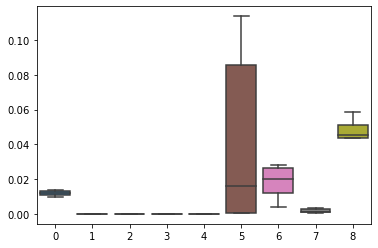

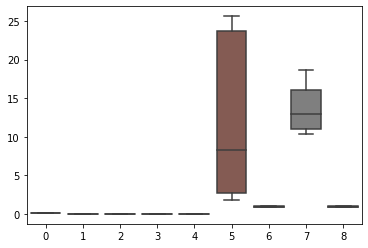

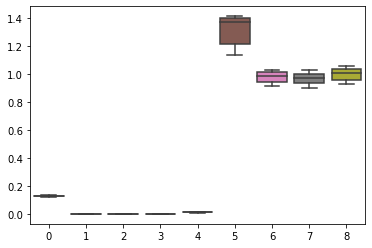

In [28]:
# degree 1
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal1_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

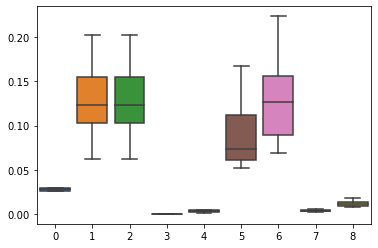

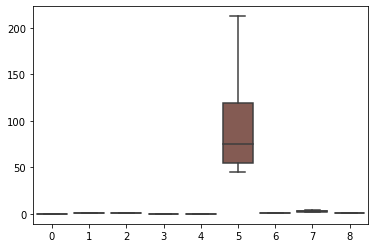

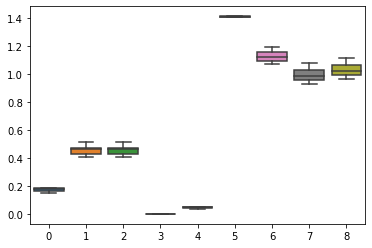

In [41]:
# degree 2
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal1_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

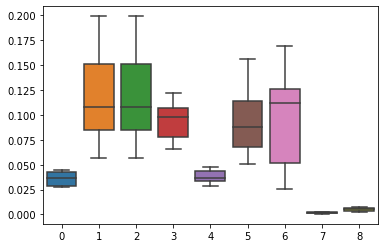

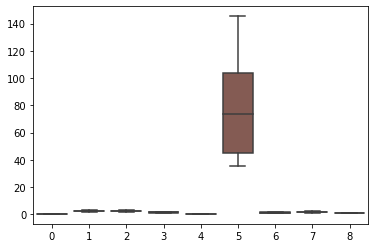

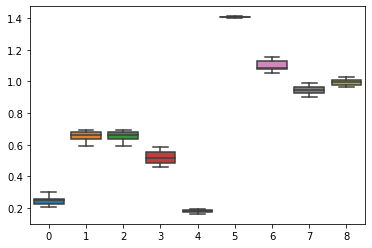

In [68]:
# degree 4
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal1_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

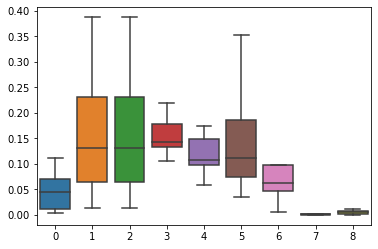

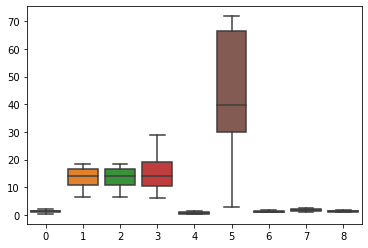

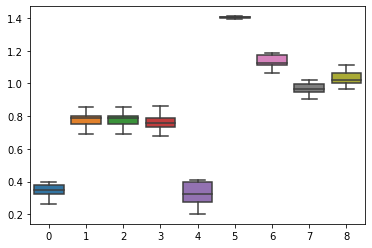

In [101]:
# degree 6
i = 3
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal1_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

In [192]:
focus = "degree"
globals()[focus + "_set"] = [1, 2, 4, 6]
total_trial = 10
methods = ['RF', 'OLS', 'Ridge', 'PolyRidge', 'RbfRidge', 'SPO+', 'ML', 'PolyKer', 'ExpRbf']
for i in range(len(methods)):
    globals()[f"Loss_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Error_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Norm_Err_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))

*********************************************************
Trial 1
Time cost 3.262002468109131
Method Random Forest
Training samples 200
Time Cost 0.18399786949157715
Loss 16.835114626149917 Error 0.5498610126491643 Normalized Error 0.2975494518340569
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9802353382110596
Loss 45.63586263392026 Error 2.319414484427286 Normalized Error 0.5668512175294591
Method Ridge Regression
Training samples 200
Time Cost 0.959789514541626
Loss 45.63586263392026 Error 2.318745215245238 Normalized Error 0.5668454959105639
Method PolyKer Ridge Regression
Training samples 200
Time Cost 3.367999315261841
Loss 120.60853196658705 Error 1.250573265424006 Normalized Error 0.5355829237301649
Method RbfKer Ridge Regression
Training samples 200
Time Cost 3.2589972019195557
Loss 3.697722587267247 Error 0.5240939875421 Normalized Error 0.17849804658829943
Method SPO+
Training samples 200


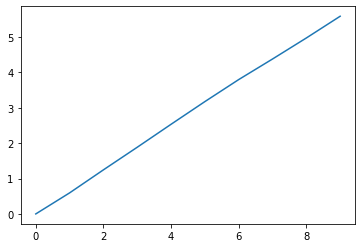

Time Cost 37.27885127067566
Loss 8.746918057086548 Error 0.9991094001488184 Normalized Error 1.1731563825275904
Method SVM Margin Learning
Training samples 200
Time Cost 0.8100004196166992
Loss 3.3246485536781627 Error 0.9997914958849103 Normalized Error 1.1542142150899835
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 12.111994743347168
Loss 3.6196348687509117 Error 0.9995325881620699 Normalized Error 1.1886868397890984
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.521740674972534
Loss 2.8449442778289833 Error 0.9998542331029703 Normalized Error 1.1705333354231513
*********************************************************
Trial 2
Time cost 3.291002035140991
Method Random Forest
Training samples 200
Time Cost 0.18200206756591797
Loss 39.003490638163726 Error 0.43765295052764797 Normalized Error 0.29067624355815247
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9450039863586426
Loss 34.0650831587445 Error 2.27040990

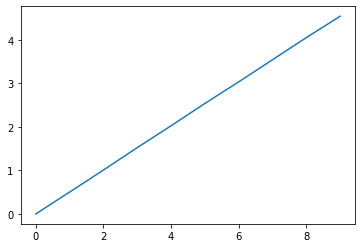

Time Cost 37.62052035331726
Loss 21.57432637421245 Error 0.9990169154690514 Normalized Error 1.1880578134417197
Method SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 0.7979981899261475
Loss 14.019264960767785 Error 0.9997130764175379 Normalized Error 1.1437073931552477
Method Poly-Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 11.490755558013916
Loss 7.6564051745661414 Error 0.9989626010961691 Normalized Error 1.1769348654239284
Method Rbf Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 10.83365249633789
Loss 7.7953895828363855 Error 0.9998156026549465 Normalized Error 1.1678190387374652
*********************************************************
Trial 3
Time cost 3.2669992446899414
Method Random Forest
Training samples 200
Time Cost 0.18200445175170898
L

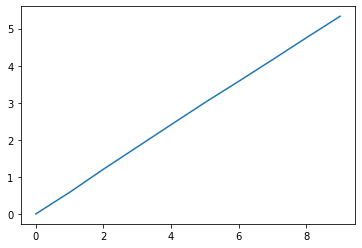

Time Cost 37.68632698059082
Loss 10.711858272223713 Error 0.9991408514282607 Normalized Error 1.1711953028864768
Method SVM Margin Learning
Training samples 200
Time Cost 0.8210020065307617
Loss 7.501698695183982 Error 0.9997408551626715 Normalized Error 1.1381649763368782
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 12.306004762649536
Loss 6.467453538427338 Error 0.9993018093940634 Normalized Error 1.1720667756628302
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.610000133514404
Loss 3.183093738465175 Error 0.9998163380927564 Normalized Error 1.1498342703674425
*********************************************************
Trial 4
Time cost 3.2700023651123047
Method Random Forest
Training samples 200
Time Cost 0.1880016326904297
Loss 19.360041728688127 Error 0.4576931000432059 Normalized Error 0.29762301732382335
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9846014976501465
Loss 47.31319863393863 Error 2.5158186878

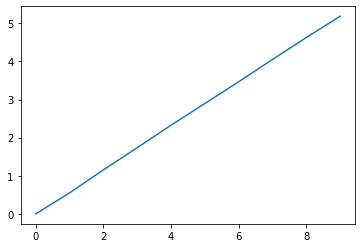

Time Cost 37.21158576011658
Loss 11.936413915854521 Error 0.9990897349183272 Normalized Error 1.1790361715325288
Method SVM Margin Learning
Training samples 200
Time Cost 0.8049981594085693
Loss 9.73607130482887 Error 0.9998114526754098 Normalized Error 1.1714503050988705
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 12.034725666046143
Loss 11.452592229768085 Error 0.9994863481568277 Normalized Error 1.2124345415828275
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.704768180847168
Loss 4.595977667427645 Error 0.9998445456896711 Normalized Error 1.1842811852266195
*********************************************************
Trial 5
Time cost 3.2705512046813965
Method Random Forest
Training samples 200
Time Cost 0.18799924850463867
Loss 19.370456035804494 Error 0.4614097480311318 Normalized Error 0.29292659060759685
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9816138744354248
Loss 27.077223486626956 Error 2.53552314

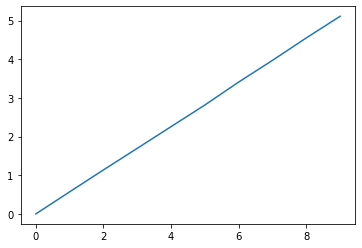

Time Cost 37.29031491279602
Loss 13.851736765070516 Error 0.9990292293731113 Normalized Error 1.1590678560322303
Method SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 0.8250002861022949
Loss 6.73531204395589 Error 0.9997270458300231 Normalized Error 1.1087440604776793
Method Poly-Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 12.323009967803955
Loss 8.86736185642247 Error 0.9990661725845678 Normalized Error 1.1229436665905788
Method Rbf Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
A_B is singular.
A_B is singular.
Time Cost 11.87141728401184
Loss 5.326305084433144 Error 0.9998027832279037 Normalized Error 1.1166515670640624
*********************************************************
Trial 6
Time cost 3.3510005474090576
Method Random Forest
Training samples 200
Time Cost 0.18699932098388672
Loss 29.588589330426725 Error 0.4127571699442077 Normali

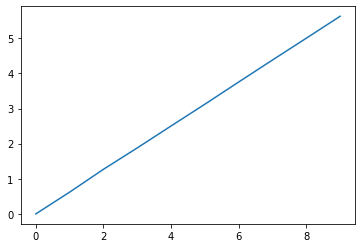

Time Cost 37.33538556098938
Loss 17.984456188156596 Error 0.9986810521164359 Normalized Error 1.1523890322215598
Method SVM Margin Learning
Training samples 200
A_B is singular.
Time Cost 0.834003210067749
Loss 12.2233804904459 Error 0.9996843444491176 Normalized Error 1.1115019964132
Method Poly-Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
Time Cost 12.654709577560425
Loss 10.552147759666607 Error 0.9990109697245257 Normalized Error 1.137260818574995
Method Rbf Kernelized SVM Margin Learning
Training samples 200
A_B is singular.
Time Cost 12.271223068237305
Loss 5.937269218045406 Error 0.9997919966362693 Normalized Error 1.1272782104998018
*********************************************************
Trial 7
Time cost 3.2739999294281006
Method Random Forest
Training samples 200
Time Cost 0.17900443077087402
Loss 23.31741501338785 Error 0.4300911855551907 Normalized Error 0.29053903169816975
Method Ordinary Least Squares
Training samples 200
Time Cost 0.978705644607

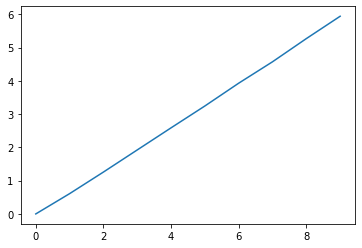

Time Cost 37.407124042510986
Loss 12.778094194825364 Error 0.9990129323574698 Normalized Error 1.172047672017644
Method SVM Margin Learning
Training samples 200
Time Cost 0.8060009479522705
Loss 5.505857040264636 Error 0.999781689870315 Normalized Error 1.1390687366059455
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.997000217437744
Loss 6.657072234613913 Error 0.9993620347419199 Normalized Error 1.1608962373103475
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.815676927566528
Loss 3.6463944954202625 Error 0.9998177703040888 Normalized Error 1.1452600348685582
*********************************************************
Trial 8
Time cost 3.429002285003662
Method Random Forest
Training samples 200
Time Cost 0.18700170516967773
Loss 62.908002865106305 Error 0.5531299267966474 Normalized Error 0.30241194308501107
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9890017509460449
Loss 44.95596546376335 Error 3.0819570049

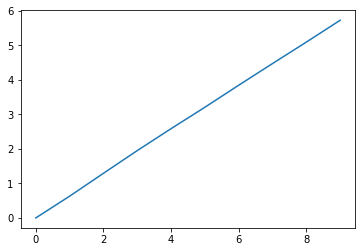

Time Cost 37.60673427581787
Loss 10.72252542250448 Error 0.998974425757093 Normalized Error 1.169660739785104
Method SVM Margin Learning
Training samples 200
Time Cost 0.8210036754608154
Loss 7.05403735226034 Error 0.9997474421106012 Normalized Error 1.1446102326389824
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 12.181744813919067
Loss 8.824321010635865 Error 0.9992737766433016 Normalized Error 1.15788727879289
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.511003494262695
Loss 2.830175538735656 Error 0.9998306105179099 Normalized Error 1.1460847343522986
*********************************************************
Trial 9
Time cost 3.3299994468688965
Method Random Forest
Training samples 200
Time Cost 0.184004545211792
Loss 24.476644733385044 Error 0.42224393042123903 Normalized Error 0.2731680899707363
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9760046005249023
Loss 26.595599074240077 Error 2.480565253729331 

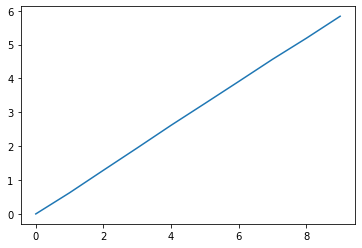

Time Cost 37.55709409713745
Loss 8.695885965545468 Error 0.9989883763815224 Normalized Error 1.1820202141438259
Method SVM Margin Learning
Training samples 200
Time Cost 0.8069984912872314
Loss 5.657382619975527 Error 0.9997793975722279 Normalized Error 1.1518777755325553
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.937146186828613
Loss 14.022333488355388 Error 0.999375760652838 Normalized Error 1.1916067792988982
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.244996309280396
Loss 2.2103445880230175 Error 0.9998556405643709 Normalized Error 1.1724204774887008
*********************************************************
Trial 10
Time cost 3.323000431060791
Method Random Forest
Training samples 200
Time Cost 0.18700027465820312
Loss 31.441139804784996 Error 0.48801194810310267 Normalized Error 0.30037216377162507
Method Ordinary Least Squares
Training samples 200
Time Cost 0.9754021167755127
Loss 26.94143342725248 Error 2.15603560

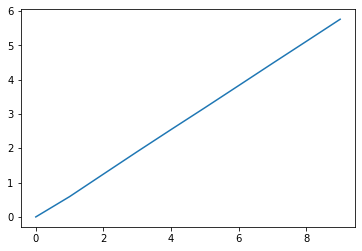

Time Cost 38.309072732925415
Loss 17.317843387112298 Error 0.9988568063978953 Normalized Error 1.1492798498051728
Method SVM Margin Learning
Training samples 200
Time Cost 0.8130011558532715
Loss 4.424560568740523 Error 0.9997134696364945 Normalized Error 1.1317913574590421
Method Poly-Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.946004390716553
Loss 10.11033953807722 Error 0.9992676582247254 Normalized Error 1.1402617768814145
Method Rbf Kernelized SVM Margin Learning
Training samples 200
Time Cost 11.333000183105469
Loss 2.149967442980214 Error 0.9998073508486544 Normalized Error 1.1282039845689464


In [268]:
for trial in range(total_trial):
    # Generate Shortest Path Samples
    benchmark = 2
    dim_edge_vert = 4
    dim_edge_hori = 4
    dim_features = 6
    dim_cost = dim_edge_hori * (dim_edge_vert + 1) + (dim_edge_hori + 1) * dim_edge_vert
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_cost, dim_features))
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 200
    # N_valid = 200
    N_test = 1000
    degree = 6
    additive_noise = 0.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.0
    attack_threshold = 0.5
    attack_power = 3.0
    z_train, c_train, A_train, b_train = dg.GenerateShortestPath(N_samples = N_train, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                                dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                                degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateShortestPath(N_samples = N_valid, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
    #                                                             dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
    #                                                             degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateShortestPath(N_samples = N_test, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    
    
    # Random Forest
    # No Theta, directly predict c
    alg = 'RF'
    print("Method Random Forest")
    print("Training samples", N_train)
    start = time.time()
    regr = RandomForestRegressor(random_state=0)
    regr.fit(z_train, c_train)
    hat_c = regr.predict(z_test)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark, A=A_test, b=b_test, c=c_test, z=z_test,
                                                                                             direct=True, hat_c=hat_c, solved = True, solution=solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Ordinary Least Squares
    alg = 'OLS'
    print("Method Ordinary Least Squares")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.OrdinaryLeastSquares(A = A_train, b = b_train, c = c_train, z = z_train)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Ridge Regression
    alg = 'Ridge'
    print("Method Ridge Regression")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = z_train, regular_const = 1e-1)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Polynomial Kernelized Ridge Regression
    alg = 'PolyRidge'
    print("Method PolyKer Ridge Regression")
    print("Training samples", N_train)
    ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=3, coef0=1.0)
    ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=3, coef0=1.0)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Rbf Kernelized Ridge Regression
    alg = 'RbfRidge'
    print("Method RbfKer Ridge Regression")
    print("Training samples", N_train)
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=5e-1)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=5e-1)
    start = time.time()
    globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = ker_z_train, regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    # SPO+
    alg = 'SPO+'
    print("Method SPO+")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.SPOplus(A = A_train, b = b_train, c = c_train, z = z_train, 
                                         regular_const = 1e-2, step_size = 1e-1, batch_size = 5, max_iter = 1e3, 
                                         solved = True, solution = solution_train)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ML'
    print("Method SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.MarginLearning(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train, 
                                                regular_const = 1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Polynomial Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'PolyKer'
    ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
    print("Method Poly-Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    
    # Rbf Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ExpRbf'
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=2e0)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=2e0)
    print("Method Rbf Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=1e-3)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])
    
    

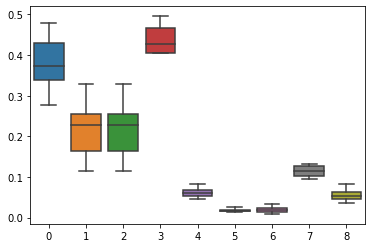

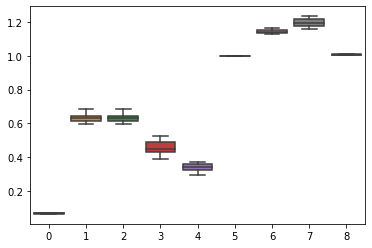

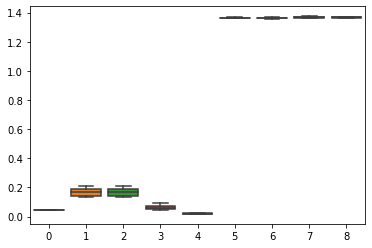

In [215]:
# degree 1
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal2_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

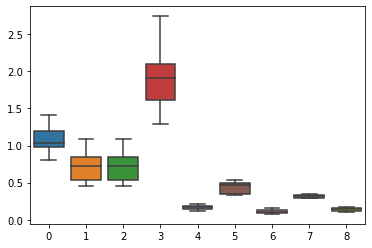

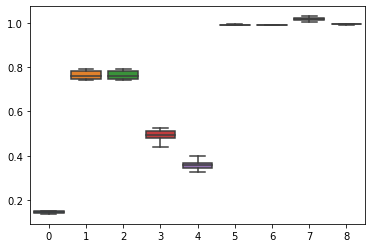

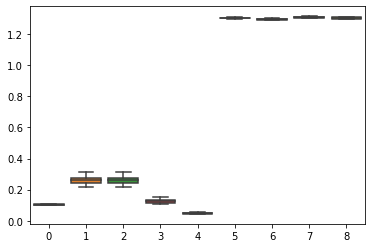

In [235]:
# degree 2
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal2_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

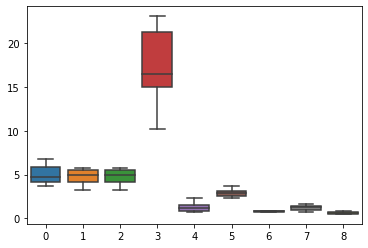

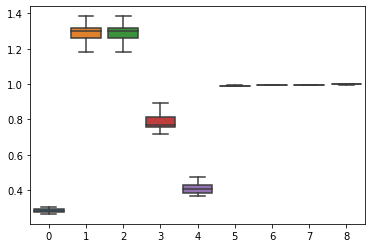

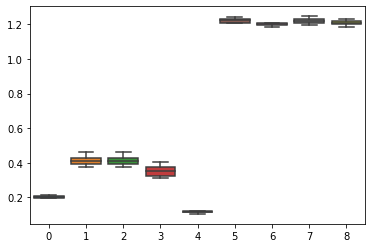

In [197]:
# degree 4
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal2_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

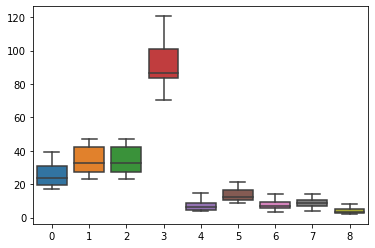

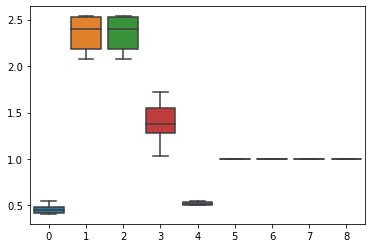

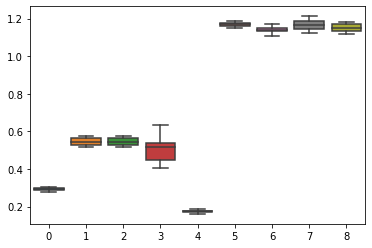

In [269]:
# degree 6
i = 3
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Rebuttal2_Degree', f"{data}_degree_{degree_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()